In [23]:
# Importarea bibliotecilor necesare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


### Încărcarea dataset-ului

In [27]:
file_path = 'datasets/Processed_Database.csv'
data = pd.read_csv(file_path)

# Preprocesare similară ca anterior (fără Yield Average)
# ... [preprocesarea completă rămasă neschimbată din versiunea anterioară] ...


### Separarea X și Y pentru fiecare target

In [28]:
targets = ['Yield of CT', 'Yield of NT']
X = data.drop(columns=targets)
y_ct = data['Yield of CT']
y_nt = data['Yield of NT']


### Funcție pentru antrenarea și evaluarea modelelor pentru un anumit target

In [30]:
def train_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "SVR": SVR(kernel='rbf', C=100, gamma='scale'),
        "XGBoost": XGBRegressor(random_state=42)
    }

    performance = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        performance[name] = {
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R^2": r2_score(y_test, y_pred)
        }
    return performance, X_train, X_test, y_train, y_test, models


### Funcție pentru tunarea modelelor cu GridSearchCV

In [31]:
def tune_models(X_train, y_train, X_test, y_test, models, target_name):
    tuned_performance = {}
    param_grid = {
        "Decision Tree": {"max_depth": [3, 5, 10, None], "min_samples_split": [2, 5]},
        "Random Forest": {"n_estimators": [50, 100], "max_depth": [5, 10, None]},
        "SVR": {"C": [1, 10, 100], "gamma": ['scale', 'auto']},
        "XGBoost": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 0.2]}
    }

    for name in param_grid:
        grid = GridSearchCV(models[name], param_grid[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        tuned_performance[name] = {
            "Best Params": grid.best_params_,
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R^2": r2_score(y_test, y_pred)
        }

        # Salvare model antrenat
        model_filename = f"best_model_{target_name.replace(' ', '_')}_{name.replace(' ', '_')}.pkl"
        joblib.dump(best_model, model_filename)
        print(f"Modelul {name} pentru {target_name} a fost salvat ca: {model_filename}")

    return tuned_performance


### Funcție pentru afișarea performanței

In [32]:
def plot_model_performance(perf_dict, tuned_dict, target_name):
    mae_values = [v["MAE"] for v in perf_dict.values()]
    mae_tuned_values = [tuned_dict.get(k, {}).get("MAE", mae_values[i]) for i, k in enumerate(perf_dict.keys())]

    rmse_values = [v["RMSE"] for v in perf_dict.values()]
    rmse_tuned_values = [tuned_dict.get(k, {}).get("RMSE", rmse_values[i]) for i, k in enumerate(perf_dict.keys())]

    r2_values = [v["R^2"] for v in perf_dict.values()]
    r2_tuned_values = [tuned_dict.get(k, {}).get("R^2", r2_values[i]) for i, k in enumerate(perf_dict.keys())]

    index = np.arange(len(perf_dict))
    bar_width = 0.35

    # MAE
    plt.figure(figsize=(12, 6))
    plt.bar(index, mae_values, bar_width, label='Netunate', color='blue')
    plt.bar(index + bar_width, mae_tuned_values, bar_width, label='Tunate', color='orange')
    plt.title(f'{target_name} - MAE')
    plt.ylabel('MAE')
    plt.xticks(index + bar_width / 2, perf_dict.keys(), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # RMSE
    plt.figure(figsize=(12, 6))
    plt.bar(index, rmse_values, bar_width, label='Netunate', color='blue')
    plt.bar(index + bar_width, rmse_tuned_values, bar_width, label='Tunate', color='orange')
    plt.title(f'{target_name} - RMSE')
    plt.ylabel('RMSE')
    plt.xticks(index + bar_width / 2, perf_dict.keys(), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # R²
    plt.figure(figsize=(12, 6))
    plt.bar(index, r2_values, bar_width, label='Netunate', color='blue')
    plt.bar(index + bar_width, r2_tuned_values, bar_width, label='Tunate', color='orange')
    plt.title(f'{target_name} - R²')
    plt.ylabel('R²')
    plt.xticks(index + bar_width / 2, perf_dict.keys(), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Performanța modelelor pentru {target_name}:")
    for name, metrics in perf_dict.items():
        print(f"{name} - Netunat - MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R^2']:.4f}")
    print(f"\nPerformanța modelelor tunate pentru {target_name}:")
    for name, metrics in tuned_dict.items():
        print(f"{name} - Tunat - MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R^2']:.4f}, Best Params: {metrics['Best Params']}")


### Aplicare pentru fiecare target și salvare modele

Author                                                 0
Soil cover in NT_No                                    0
Longitude                                              0
N input rates with the unit kg N ha-1 (details)        0
N input_No                                             0
N input_Yes                                            0
PB                                                     0
Relative yield change                                  0
Residue management of previous crop in NT (details)    0
ST_Clay loam                                           0
dtype: int64
Modelul Decision Tree pentru Yield of CT a fost salvat ca: best_model_Yield_of_CT_Decision_Tree.pkl
Modelul Random Forest pentru Yield of CT a fost salvat ca: best_model_Yield_of_CT_Random_Forest.pkl
Modelul SVR pentru Yield of CT a fost salvat ca: best_model_Yield_of_CT_SVR.pkl
Modelul XGBoost pentru Yield of CT a fost salvat ca: best_model_Yield_of_CT_XGBoost.pkl


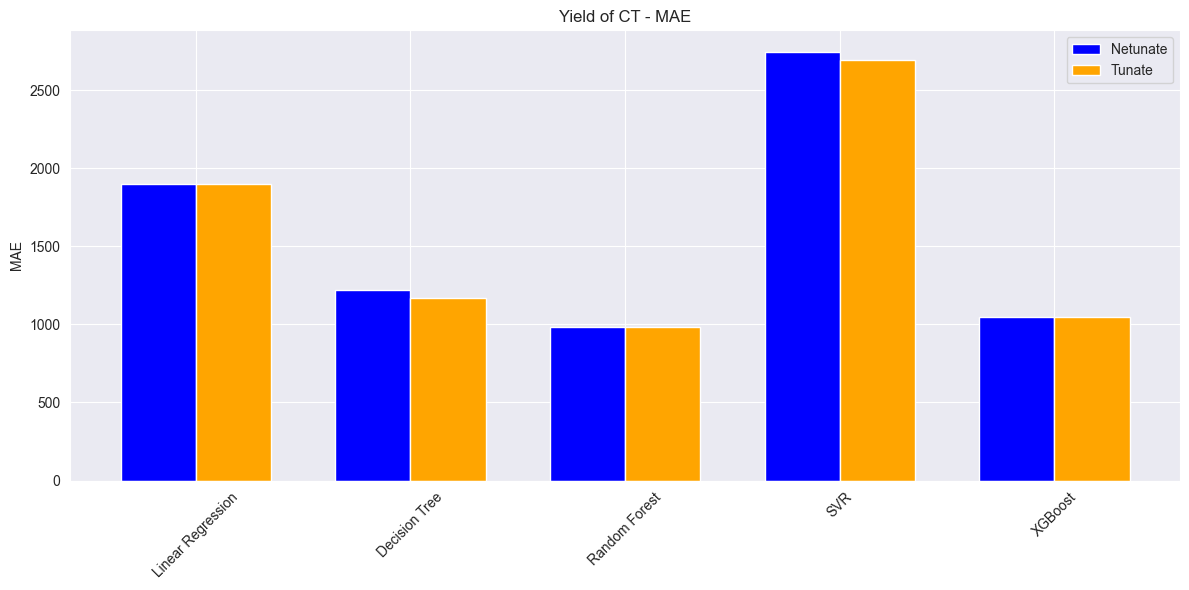

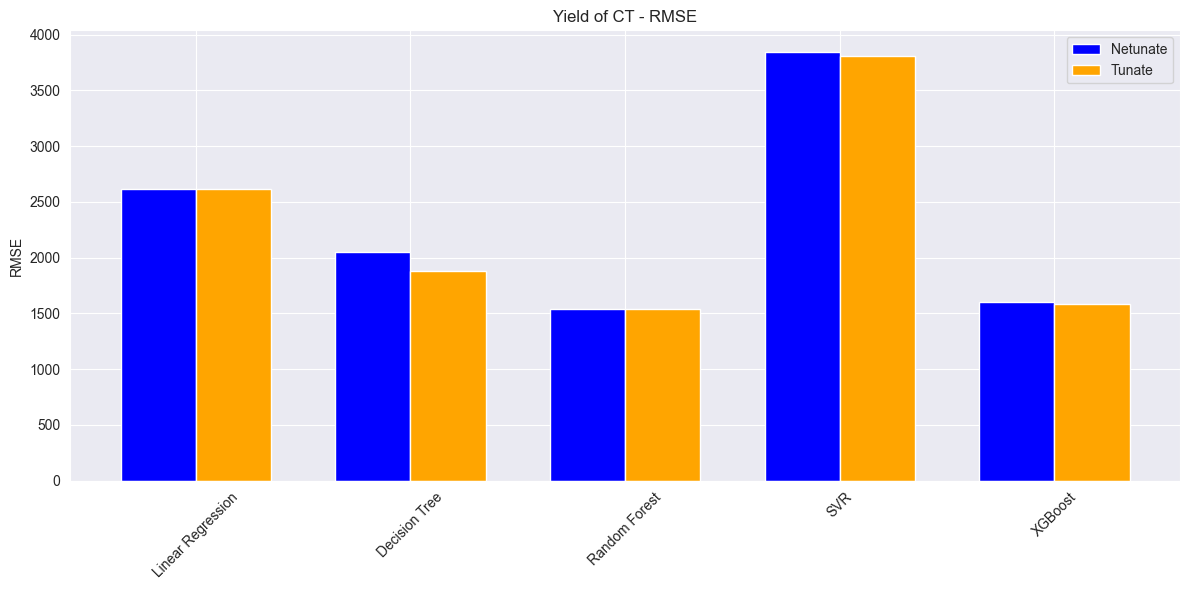

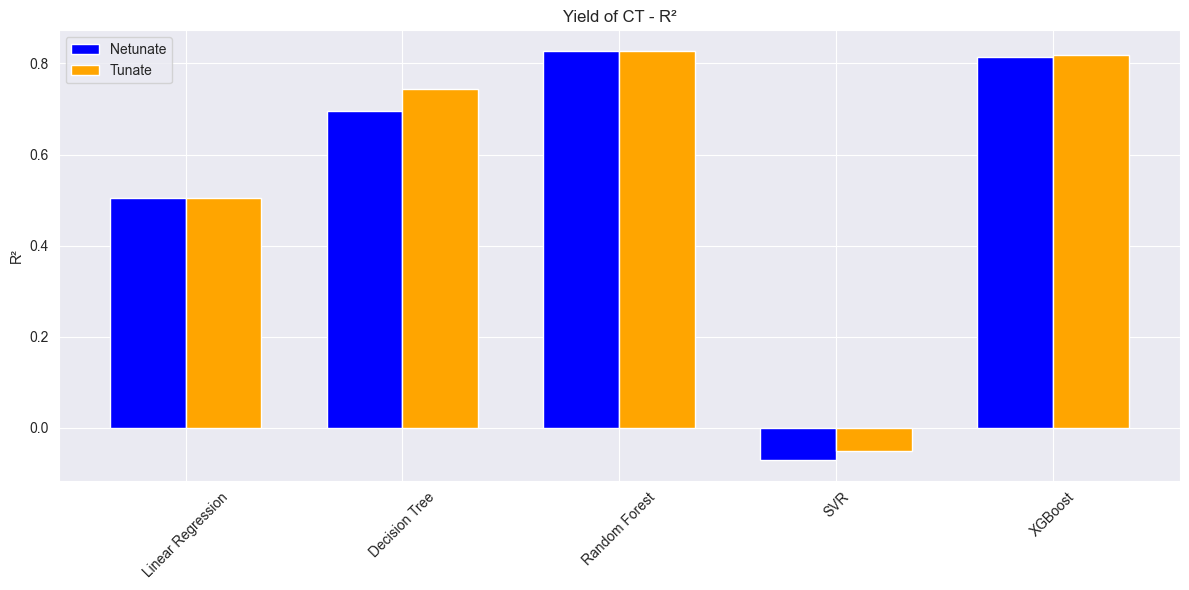

Performanța modelelor pentru Yield of CT:
Linear Regression - Netunat - MAE: 1902.3637, RMSE: 2615.1234, R²: 0.5051
Decision Tree - Netunat - MAE: 1218.3452, RMSE: 2053.2218, R²: 0.6949
Random Forest - Netunat - MAE: 981.3413, RMSE: 1543.1901, R²: 0.8277
SVR - Netunat - MAE: 2746.3026, RMSE: 3846.8004, R²: -0.0708
XGBoost - Netunat - MAE: 1048.7666, RMSE: 1598.8139, R²: 0.8150

Performanța modelelor tunate pentru Yield of CT:
Decision Tree - Tunat - MAE: 1166.1742, RMSE: 1878.5293, R²: 0.7446, Best Params: {'max_depth': None, 'min_samples_split': 5}
Random Forest - Tunat - MAE: 981.3413, RMSE: 1543.1901, R²: 0.8277, Best Params: {'max_depth': None, 'n_estimators': 100}
SVR - Tunat - MAE: 2691.8545, RMSE: 3810.8543, R²: -0.0509, Best Params: {'C': 100, 'gamma': 'auto'}
XGBoost - Tunat - MAE: 1050.1628, RMSE: 1582.0998, R²: 0.8189, Best Params: {'learning_rate': 0.2, 'n_estimators': 100}
Modelul Decision Tree pentru Yield of NT a fost salvat ca: best_model_Yield_of_NT_Decision_Tree.pkl
M

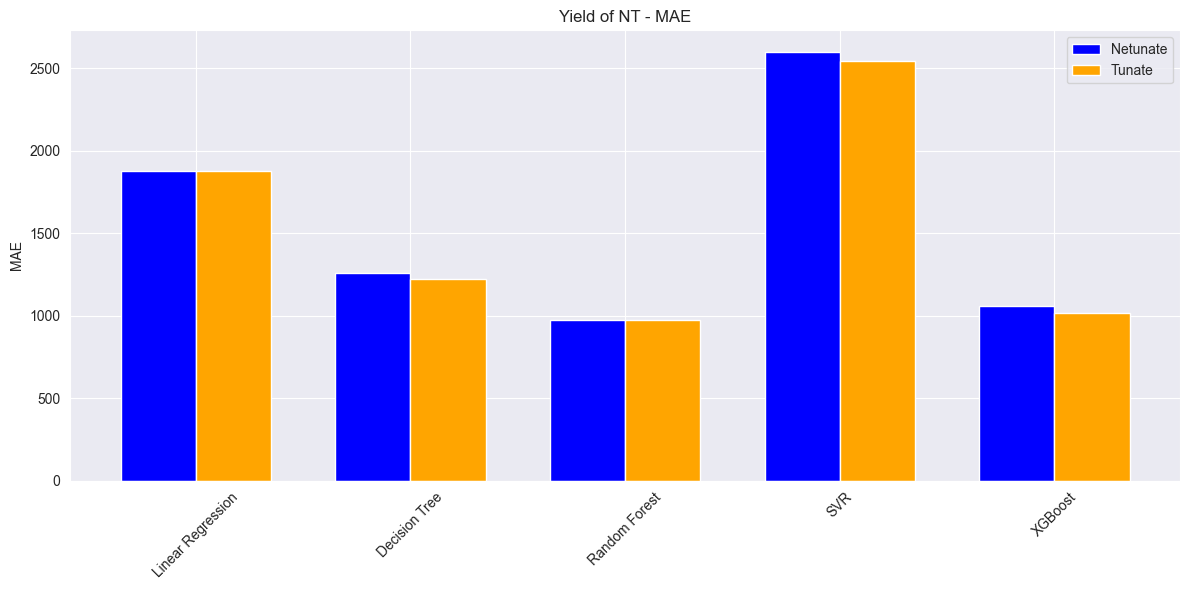

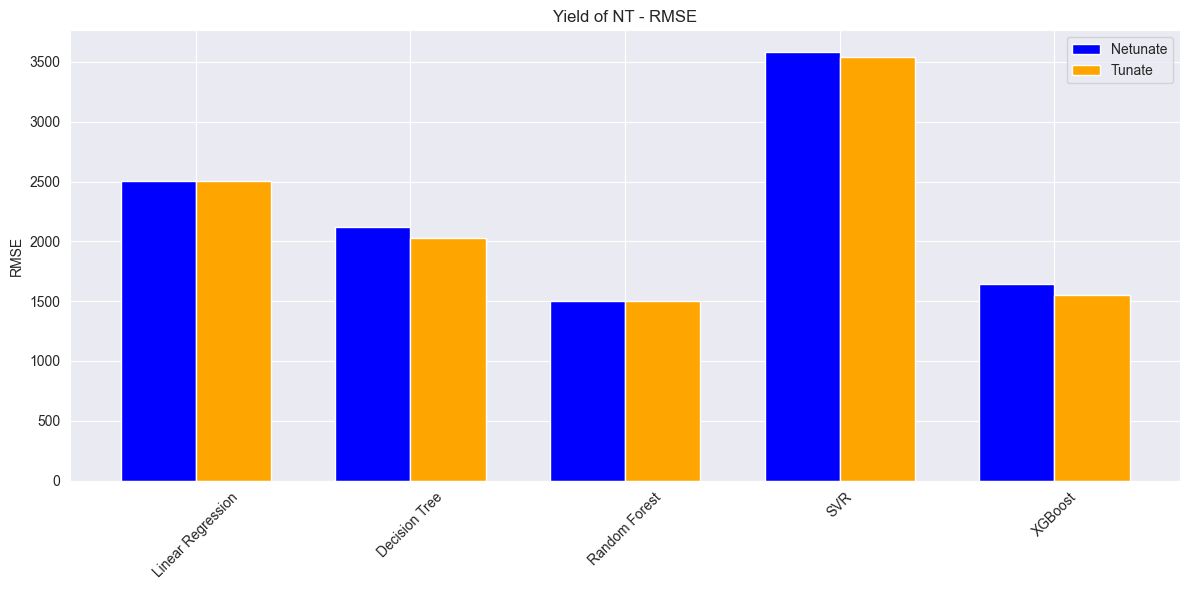

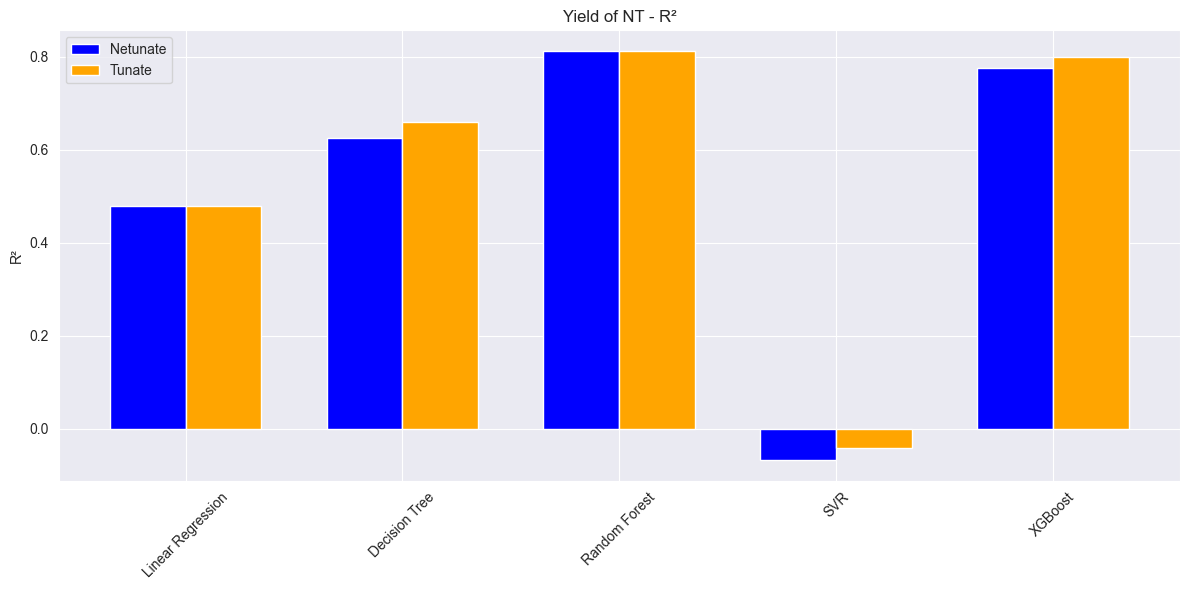

Performanța modelelor pentru Yield of NT:
Linear Regression - Netunat - MAE: 1876.4691, RMSE: 2507.5352, R²: 0.4779
Decision Tree - Netunat - MAE: 1261.2300, RMSE: 2123.8517, R²: 0.6254
Random Forest - Netunat - MAE: 972.1239, RMSE: 1503.2350, R²: 0.8124
SVR - Netunat - MAE: 2600.8324, RMSE: 3585.4416, R²: -0.0675
XGBoost - Netunat - MAE: 1059.3348, RMSE: 1644.2431, R²: 0.7755

Performanța modelelor tunate pentru Yield of NT:
Decision Tree - Tunat - MAE: 1223.9211, RMSE: 2025.8404, R²: 0.6592, Best Params: {'max_depth': None, 'min_samples_split': 5}
Random Forest - Tunat - MAE: 972.1239, RMSE: 1503.2350, R²: 0.8124, Best Params: {'max_depth': None, 'n_estimators': 100}
SVR - Tunat - MAE: 2542.6042, RMSE: 3540.1864, R²: -0.0407, Best Params: {'C': 100, 'gamma': 'auto'}
XGBoost - Tunat - MAE: 1015.9580, RMSE: 1552.8065, R²: 0.7998, Best Params: {'learning_rate': 0.2, 'n_estimators': 100}


In [33]:
print(X.isnull().sum().sort_values(ascending=False).head(10))

performance_ct, X_train_ct, X_test_ct, y_train_ct, y_test_ct, models_ct = train_models(X, y_ct)
tuned_performance_ct = tune_models(X_train_ct, y_train_ct, X_test_ct, y_test_ct, models_ct, "Yield of CT")
plot_model_performance(performance_ct, tuned_performance_ct, "Yield of CT")

performance_nt, X_train_nt, X_test_nt, y_train_nt, y_test_nt, models_nt = train_models(X, y_nt)
tuned_performance_nt = tune_models(X_train_nt, y_train_nt, X_test_nt, y_test_nt, models_nt, "Yield of NT")
plot_model_performance(performance_nt, tuned_performance_nt, "Yield of NT")


In [34]:
### Predicție pentru o parcelă nouă
# Exemplu de parcelă nouă (trebuie adaptat la coloanele reale)
new_parcel = {
    'Author': 0,
    'Crop growing season recorded in the paper': 0,
    'Crop sequence (details)_1': 0,
    'Crop_barley.winter': 0,
    'Crop_cotton': 0,
    'Crop_maize': 1,
    'Crop_rice': 0,
    'Crop_sorghum': 0,
    'Crop_soybean': 0,
    'Crop_sunflower': 0,
    'Crop_tomato': 0,
    'Crop_wheat.spring': 0,
    'Crop_wheat.winter': 0,
    'Fertilization CT_Yes': 1,
    'Fertilization NT_Yes': 0,
    'Geographical coordinates available_Yes': 0,
    'Irrigation CT_Yes': 1,
    'Irrigation NT_Yes': 0,
    'Land gradient_Yes': 0,
    'Latitude': 46.8,
    'Longitude': 23.6,
    'Measured water productivity_Yes': 0,
    'Mulching CT_Yes': 0,
    'Mulching NT_Yes': 0,
    'N fertilization CT_Yes': 0,
    'N fertilization NT_Yes': 0,
    'pH (surface layer)': 6.5,
    'P fertilization CT_Yes': 0,
    'P fertilization NT_Yes': 0,
    'Previous crop_Yes': 0,
    'Rainfall': 300,
    'Residue burning in CT_Yes': 0,
    'Residue burning in NT_Yes': 0,
    'Residue retained in CT_Yes': 0,
    'Residue retained in NT_Yes': 0,
    'Replications in experiment': 3,
    'Soil bulk density': 1.3,
    'Soil cover in CT_Yes': 0,
    'Soil cover in NT_Yes': 0,
    'Soil organic carbon (surface layer)': 2.0,
    'Soil texture available_Yes': 0,
    'Sowing date available_Yes': 0,
    'Sowing month': 0,
    'Sowing year': 2023,
    'Tmax': 27,
    'Tmin': 14,
    'Water applied in CT': 200,
    'Water applied in NT': 0,
    'Year': 2023,
    'Years since NT started (yrs)': 0,
    'Yield increase with NT_Yes': 0
}

# Conversie și aliniere cu coloanele folosite la antrenare
X_new = pd.DataFrame([new_parcel])
X_new = X_new.reindex(columns=X_train_ct.columns, fill_value=0)

# Încărcare model salvat și predicție
model_ct = joblib.load('best_model_Yield_of_CT_Random_Forest.pkl')
predicted_yield_ct = model_ct.predict(X_new)[0]
print(f"Predicted Yield of CT pentru noua parcelă: {predicted_yield_ct:.2f}")


Predicted Yield of CT pentru noua parcelă: 16983.14


In [36]:
new_parcel_nt = {
    'Author': 0,
    'Crop growing season recorded in the paper': 0,
    'Crop sequence (details)_1': 0,
    'Crop_barley.winter': 0,
    'Crop_cotton': 0,
    'Crop_maize': 1,
    'Crop_rice': 0,
    'Crop_sorghum': 0,
    'Crop_soybean': 0,
    'Crop_sunflower': 0,
    'Crop_tomato': 0,
    'Crop_wheat.spring': 0,
    'Crop_wheat.winter': 0,
    'Fertilization CT_Yes': 1,
    'Fertilization NT_Yes': 1,
    'Geographical coordinates available_Yes': 0,
    'Irrigation CT_Yes': 1,
    'Irrigation NT_Yes': 1,
    'Land gradient_Yes': 0,
    'Latitude': 46.8,
    'Longitude': 23.6,
    'Measured water productivity_Yes': 0,
    'Mulching CT_Yes': 0,
    'Mulching NT_Yes': 0,
    'N fertilization CT_Yes': 0,
    'N fertilization NT_Yes': 0,
    'pH (surface layer)': 6.5,
    'P fertilization CT_Yes': 0,
    'P fertilization NT_Yes': 0,
    'Previous crop_Yes': 0,
    'Rainfall': 300,
    'Residue burning in CT_Yes': 0,
    'Residue burning in NT_Yes': 0,
    'Residue retained in CT_Yes': 0,
    'Residue retained in NT_Yes': 0,
    'Replications in experiment': 3,
    'Soil bulk density': 1.3,
    'Soil cover in CT_Yes': 0,
    'Soil cover in NT_Yes': 0,
    'Soil organic carbon (surface layer)': 2.0,
    'Soil texture available_Yes': 0,
    'Sowing date available_Yes': 0,
    'Sowing month': 0,
    'Sowing year': 2023,
    'Tmax': 27,
    'Tmin': 14,
    'Water applied in CT': 200,
    'Water applied in NT': 180,
    'Year': 2023,
    'Years since NT started (yrs)': 2,
    'Yield increase with NT_Yes': 1
}

import pandas as pd
import joblib

# Transformăm în DataFrame
X_new_nt = pd.DataFrame([new_parcel_nt])
X_new_nt = X_new_nt.reindex(columns=X_train_nt.columns, fill_value=0)

# Încărcăm modelul
model_nt = joblib.load('best_model_Yield_of_NT_Random_Forest.pkl')

# Facem predicția
predicted_yield_nt = model_nt.predict(X_new_nt)[0]
print(f"Predicted Yield of NT: {predicted_yield_nt:.2f}")

Predicted Yield of NT: 14607.65
